# Get network stats

In this notebook we count for number of nodes and edges for each node and edge type.

In [25]:
# Import statements
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx
import random
from tqdm import tqdm
import numpy as np

for file in os.listdir("./Network/"):
    if file.endswith(".csv"):
        df = pd.read_csv("./Network/" + file)
        print(file, len(df))


Authors.Publications.Publications.edges.csv 1260
Publications.nodes.csv 1640
Awards.nodes.csv 683
Publications.Awards.Awards.edges.csv 2807
MeSH.MeSH.Publications.edges.csv 12634
Awards.Awards.Publications.edges.csv 2807
Awards.Awards.Authors.edges.csv 683
Authors.Awards.Awards.edges.csv 683
Authors.nodes.csv 458
Publications.Publications.Authors.edges.csv 1260
MeSH.nodes.csv 2736
Publications.MeSH.MeSH.edges.csv 12634
Authors.Coauthors.Authors.edges.csv 728


Get total network nodes and edges.

In [26]:
# Create variables for node and edge counts.
node_count = 0
edge_count = 0 

# Iterate over node files to get node counts.
for file in os.listdir("./Network/"):
    if file.endswith(".nodes.csv"):
        df = pd.read_csv("./Network/" + file)
        node_count += len(df)
    elif file.endswith(".edges.csv"):
        df = pd.read_csv("./Network/" + file)
        edge_count += len(df)

# Print out node and edge counts.
print(f"Total Node Count: {node_count}")
print(f"Total Edge Count: {edge_count}")

Total Node Count: 5517
Total Edge Count: 35496


Now let us create plots for the node connectivity distribution.

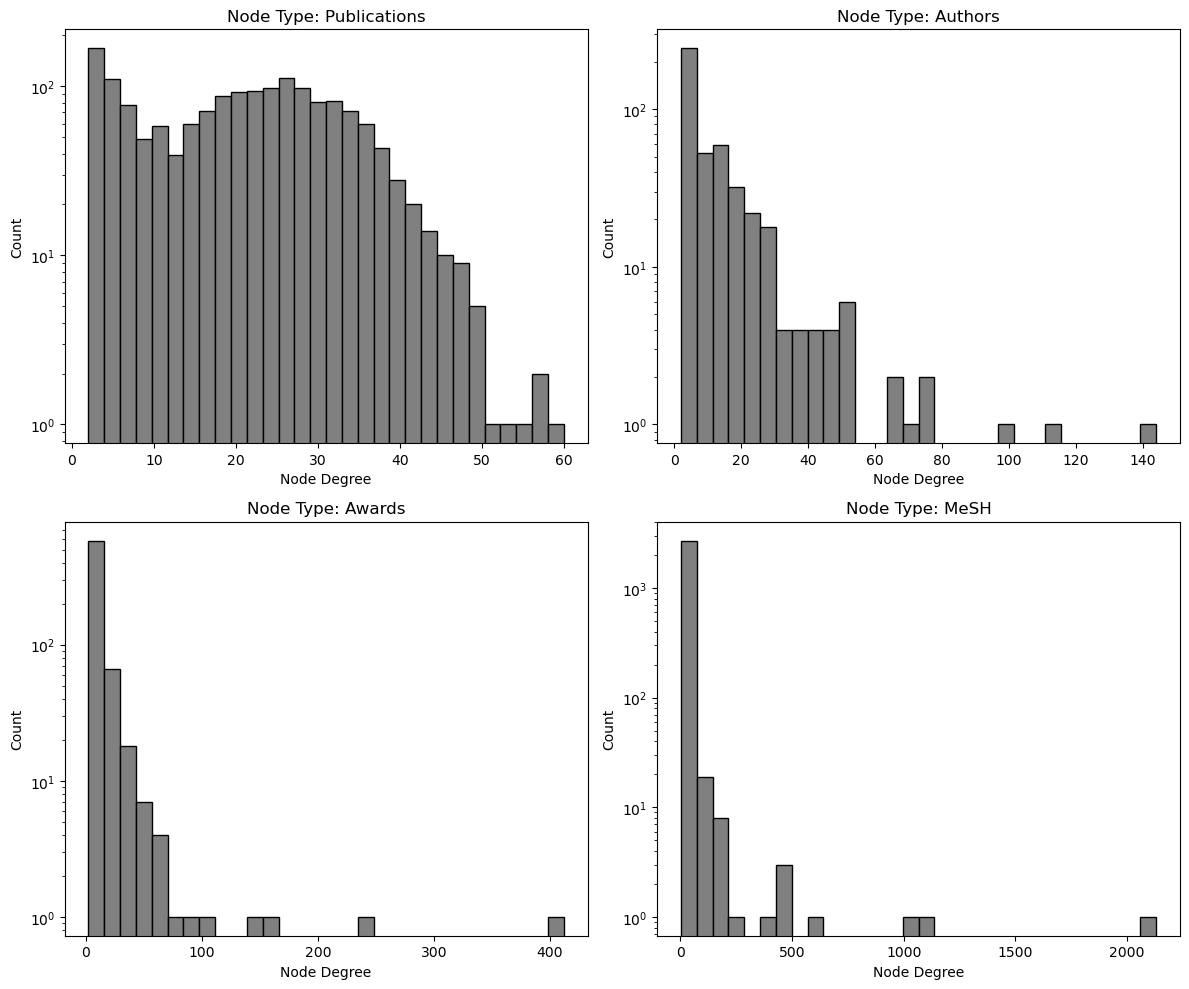

In [27]:


# Initialize structures
node_type_map = {}
node_degrees = defaultdict(int)

network_path = "./Network/"

# Step 1: Map node IDs to their types
for file in os.listdir(network_path):
    if file.endswith(".nodes.csv"):
        df = pd.read_csv(os.path.join(network_path, file), usecols=['id'])
        node_type = file.replace(".nodes.csv", "")
        for node_id in df['id']:
            node_type_map[node_id] = node_type

# Step 2: Count degrees
for file in os.listdir(network_path):
    if file.endswith(".edges.csv"):
        df = pd.read_csv(os.path.join(network_path, file), usecols=['source', 'target'])
        for src, tgt in zip(df['source'], df['target']):
            node_degrees[src] += 1
            node_degrees[tgt] += 1

# Step 3: Aggregate degree by type
degree_by_type = defaultdict(list)
for node_id, degree in node_degrees.items():
    node_type = node_type_map.get(node_id, "Unknown")
    degree_by_type[node_type].append(degree)

# Step 4: Plot 2x2 subplots
node_types = list(degree_by_type.keys())
num_plots = len(node_types)
rows, cols = 2, 2

fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
axes = axes.flatten()

for i, node_type in enumerate(node_types[:4]):
    ax = axes[i]
    ax.hist(degree_by_type[node_type], bins=30, edgecolor='black', color='gray')
    ax.set_title(f"Node Type: {node_type}")
    ax.set_xlabel("Node Degree")
    ax.set_ylabel("Count")
    ax.set_yscale("log")

# Hide unused subplots
for j in range(len(node_types), rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Now let us calculate the avg of shortest paths.

In [28]:
network_path = "./Network/"
G = nx.Graph()
node_type_map = {}

# Load node types
for file in os.listdir(network_path):
    if file.endswith(".nodes.csv"):
        node_type = file.replace(".nodes.csv", "")
        df = pd.read_csv(os.path.join(network_path, file), usecols=['id'])
        for node_id in df['id']:
            node_type_map[node_id] = node_type

# Load edges
for file in os.listdir(network_path):
    if file.endswith(".edges.csv"):
        df = pd.read_csv(os.path.join(network_path, file), usecols=['source', 'target'])
        G.add_edges_from(zip(df['source'], df['target']))

# Compute all-pairs shortest paths
all_lengths = []
type_lengths = defaultdict(list)

for source, targets in tqdm(nx.all_pairs_shortest_path_length(G), total=len(G), desc="Computing paths"):
    source_type = node_type_map.get(source, "Unknown")
    for target, dist in targets.items():
        if source != target:
            all_lengths.append(dist)
            if node_type_map.get(target, "Unknown") == source_type:
                type_lengths[source_type].append(dist)

# Print results
print(f"\nTotal Average Shortest Path Length: {np.mean(all_lengths):.4f}")
for ntype, lengths in type_lengths.items():
    print(f"Avg Path Length within node type '{ntype}': {np.mean(lengths):.4f}")



Computing paths: 100%|██████████| 5517/5517 [00:16<00:00, 339.30it/s]



Total Average Shortest Path Length: 3.9474
Avg Path Length within node type 'Publications': 3.1760
Avg Path Length within node type 'Authors': 4.7424
Avg Path Length within node type 'Awards': 4.6906
Avg Path Length within node type 'MeSH': 4.1213


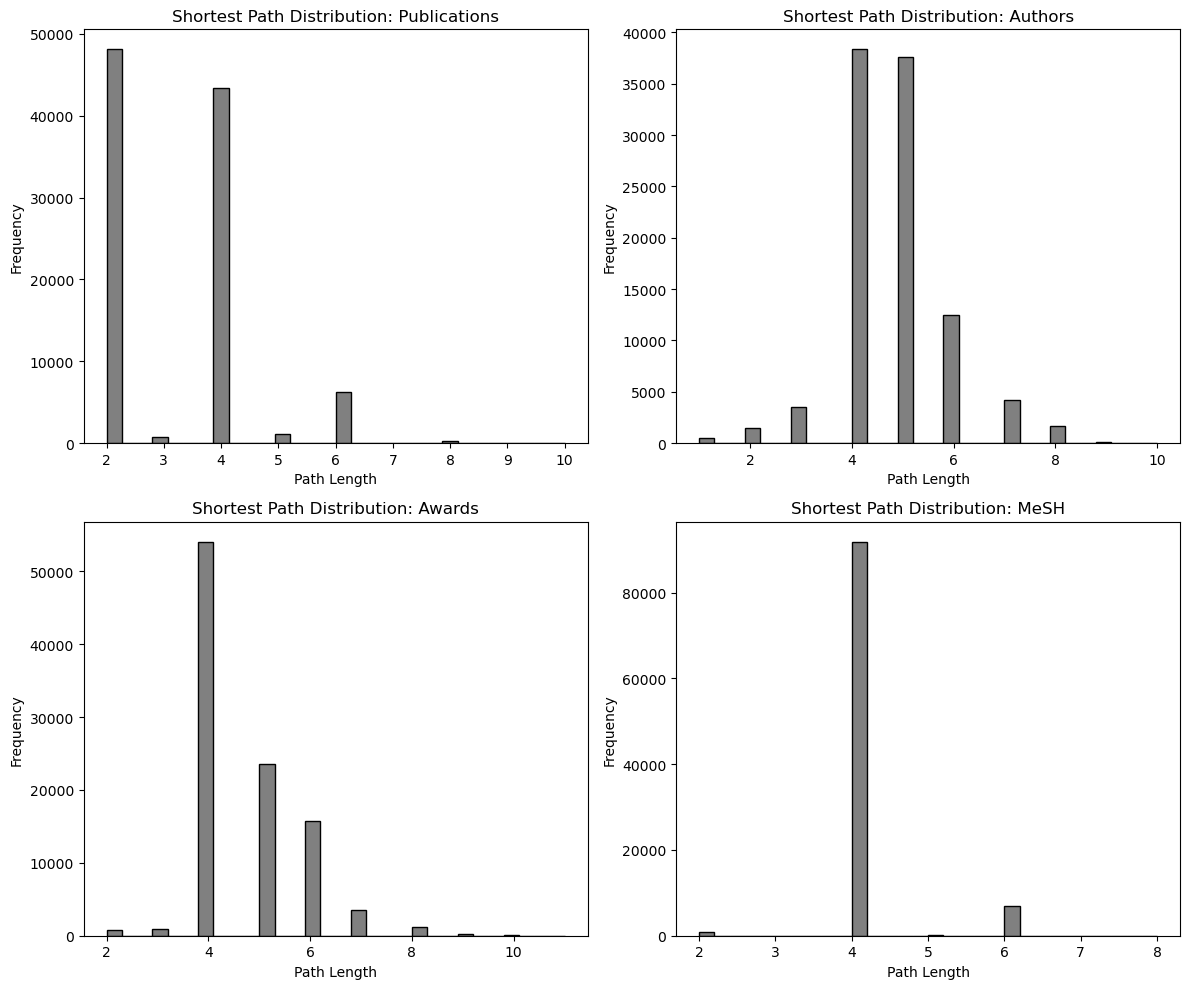

In [29]:
import random
sampled_lengths_by_type = {
    ntype: random.sample(lengths, min(100000, len(lengths)))
    for ntype, lengths in type_lengths.items()
}
# Create subplots for each node type
node_types = list(sampled_lengths_by_type.keys())
ncols = 2
nrows = (len(node_types) + 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
axes = axes.flatten()

for i, ntype in enumerate(node_types):
    ax = axes[i]
    ax.hist(sampled_lengths_by_type[ntype], bins=30, edgecolor='black', color='gray')
    ax.set_title(f"Shortest Path Distribution: {ntype}")
    ax.set_xlabel("Path Length")
    ax.set_ylabel("Frequency")

# Remove unused subplots
for j in range(len(node_types), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Now let us compute all of the top node types by each edge type (i.e. top Author by number of coauthors, top Author by number of publications...)

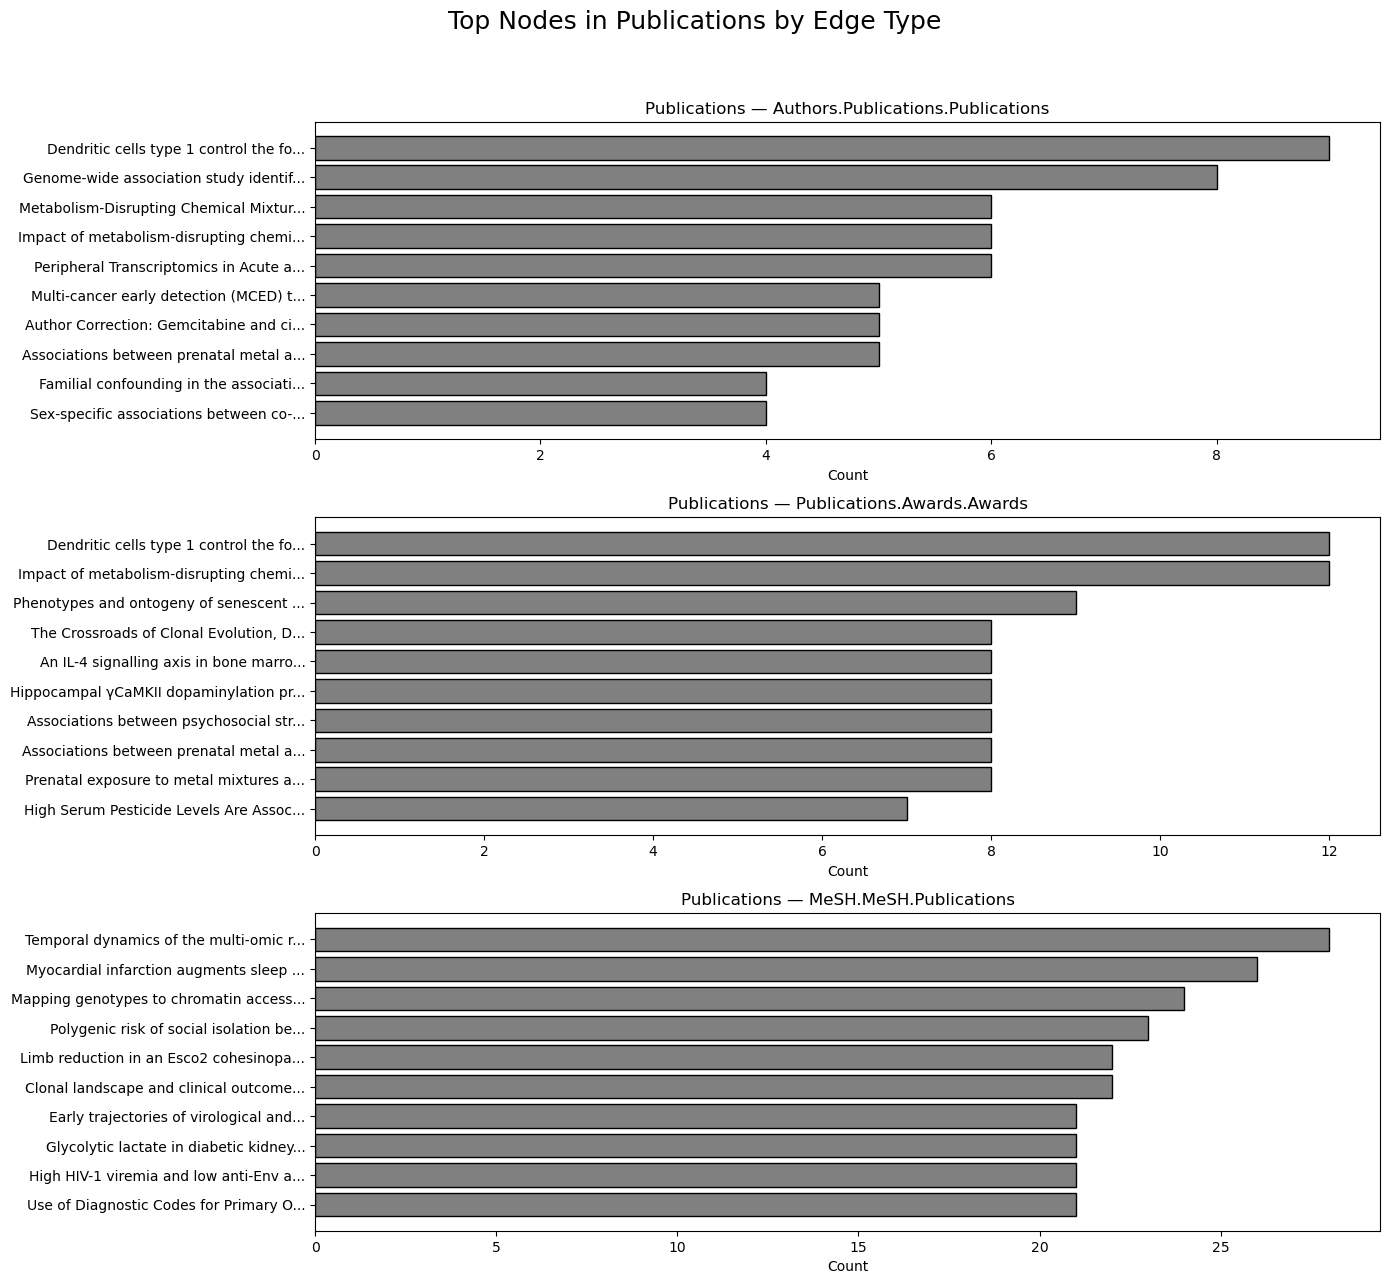

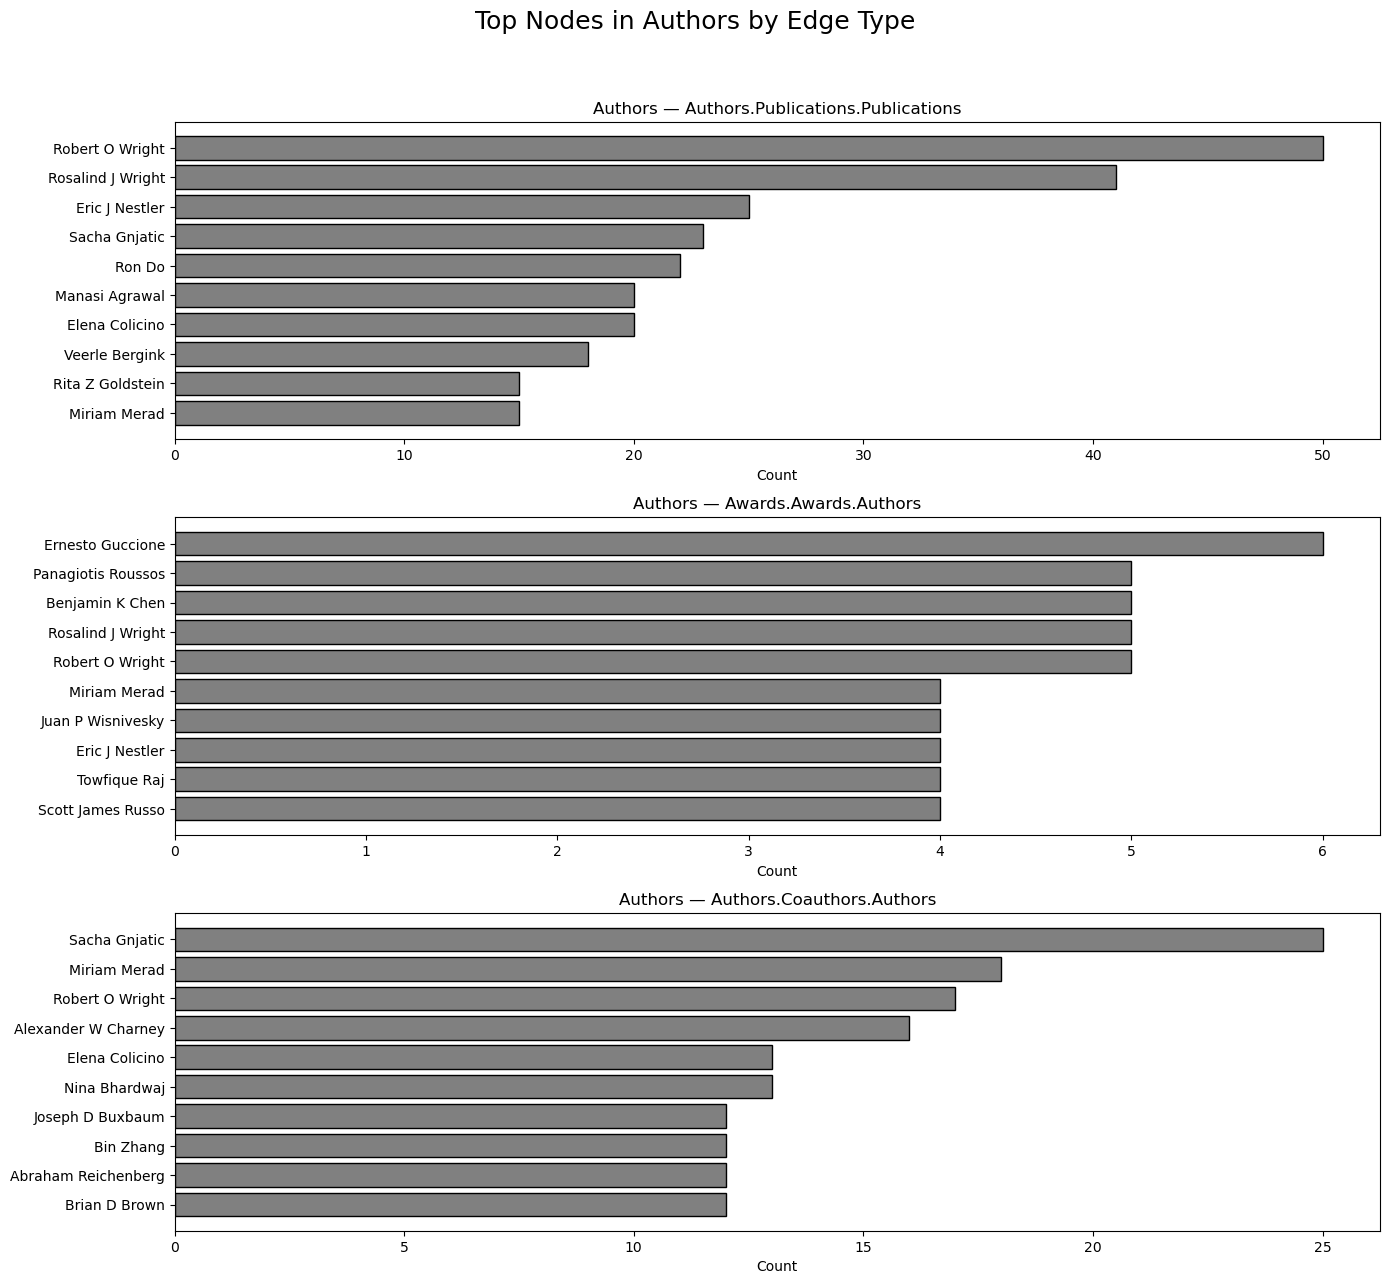

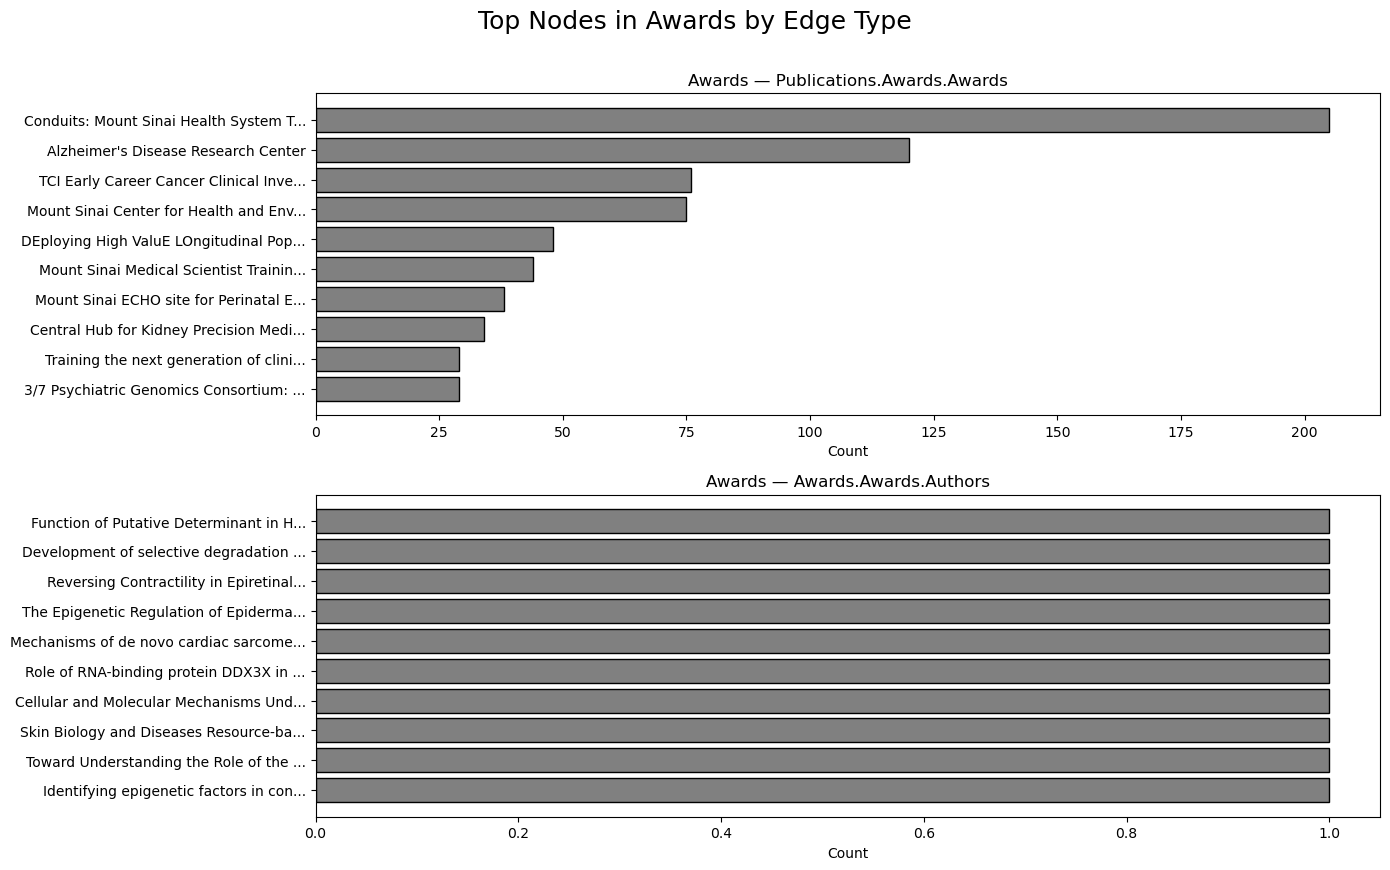

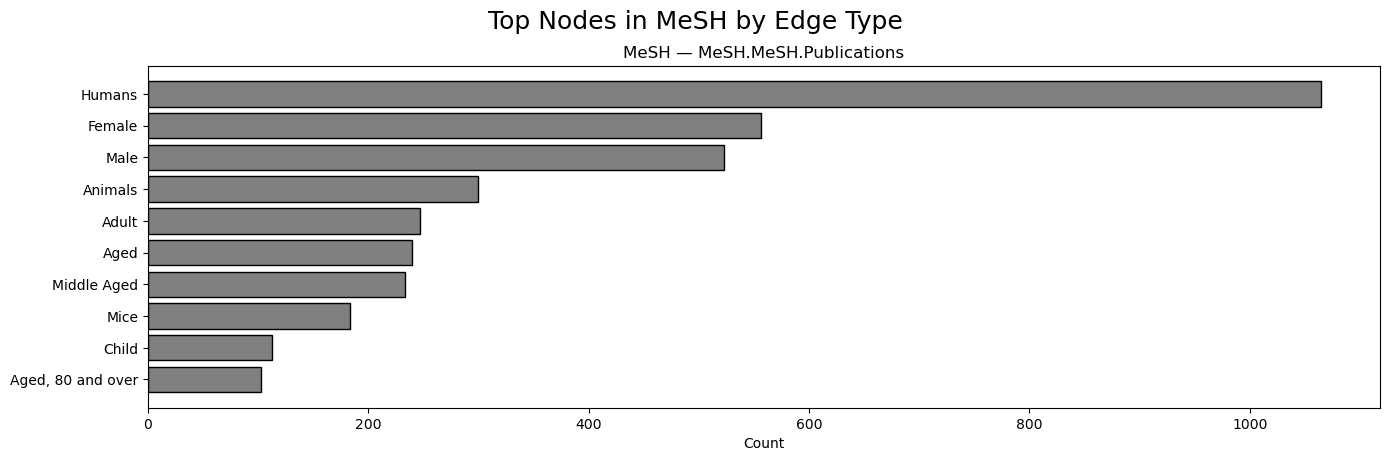

In [30]:

network_path = "./Network/"
node_labels = {}
node_types = {}

# Step 1: Load node labels (or titles) and types
for file in os.listdir(network_path):
    if file.endswith(".nodes.csv"):
        node_type = file.replace(".nodes.csv", "")
        df = pd.read_csv(os.path.join(network_path, file))

        # Choose Title if it's Publications or Awards
        if node_type in ["Publications", "Awards"] and "Title" in df.columns:
            label_col = "Title"
        else:
            label_col = "label"

        df['id'] = df['id'].astype(str)
        df[label_col] = df[label_col].astype(str)

        for node_id, label in zip(df['id'], df[label_col]):
            node_labels[node_id] = label
            node_types[node_id] = node_type

# Step 2: Compute degrees per edge type, avoiding reversed duplicates
edge_type_degrees = defaultdict(lambda: defaultdict(list))  # node_type -> edge_type -> [(label, degree)]
seen_pairs = set()

for file in os.listdir(network_path):
    if file.endswith(".edges.csv"):
        edge_type_full = file.replace(".edges.csv", "")
        parts = edge_type_full.split('.')
        if len(parts) < 3:
            continue

        type1, _, type2 = parts[0], parts[1], parts[2]
        type_pair = tuple(sorted((type1, type2)))

        if type_pair in seen_pairs:
            continue
        seen_pairs.add(type_pair)

        edge_type = edge_type_full

        # Load edges and cast to str
        df = pd.read_csv(os.path.join(network_path, file), usecols=['source', 'target'])
        df['source'] = df['source'].astype(str)
        df['target'] = df['target'].astype(str)

        G = nx.Graph()
        G.add_edges_from(zip(df['source'], df['target']))

        for node, deg in G.degree():
            ntype = node_types.get(node, "Unknown")
            label = node_labels.get(node, node)
            edge_type_degrees[ntype][edge_type].append((label, deg))

# Step 3: Plot top nodes for each node type by edge type
for node_type, edge_map in edge_type_degrees.items():
    edge_types = list(edge_map.keys())
    ncols = 1
    nrows = (len(edge_types) + 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows))
    axes = axes.flatten()

    for i, edge_type in enumerate(edge_types):
        top = sorted(edge_map[edge_type], key=lambda x: x[1], reverse=True)[:10]
        raw_labels, degrees = zip(*top)

        # Truncate labels to 20 characters max
        labels = [label if len(label) <= 40 else label[:37] + "..." for label in raw_labels]

        ax = axes[i]
        ax.barh(labels[::-1], degrees[::-1], color='gray', edgecolor='black')
        ax.set_title(f"{node_type} — {edge_type}")
        ax.set_xlabel("Count")

    # Remove unused subplots
    for j in range(len(edge_types), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"Top Nodes in {node_type} by Edge Type", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


